In [1]:
#-----------------------------------------
# Problem Set 2: Dynamic Discrete Choice
#   Tanya Rajan and George Vojta
# 
#
# We would like to thank Jeanne Sorin,
# Michael Cuna, Alex Petrov, & Nadia Lucas 
# for helpful comments on our code
#-----------------------------------------

# Importing packages #
from jax import numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import math
from scipy.stats import norm
import scipy.integrate as integrate
import scipy
from random import choices
from numpy import matlib
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from scipy.stats import mode
from scipy.sparse import identity
from scipy.sparse.linalg import inv as spinv
from scipy.sparse.linalg import spsolve as spsolve
from scipy.optimize import minimize
from numpy.linalg import eig
import gurobipy as gp
from gurobipy import *
from linearmodels.iv import IV2SLS, IVGMM
import jax.numpy as jnp
import jax
import pyblp
from jax import core
np.random.seed(1)

In [2]:
### initialize data ###

df = pd.read_csv('psetTwo.csv')
df['milage_last'] = df['milage'].shift(+1)
df['milage_next'] = df['milage'].shift(-1)
df['d'] = 0

df['t'] = df['milage']-df['milage_last']

df.loc[df['milage_last'] > df['milage'], 'd'] = 1
df.loc[df['d'] == 1, 't'] = df['milage']

df.head(20)

,milage,milage_last,milage_next,d,t
0,23,NaN,31.0,0,NaN
1,31,23.0,36.0,0,8.0
2,36,31.0,46.0,0,5.0
3,46,36.0,56.0,0,10.0
4,56,46.0,66.0,0,10.0
5,66,56.0,75.0,0,10.0
6,75,66.0,85.0,0,9.0
7,85,75.0,86.0,0,10.0
8,86,85.0,95.0,0,1.0
9,95,86.0,106.0,0,9.0


Mileage min is:  1
Mileage Max is:  221


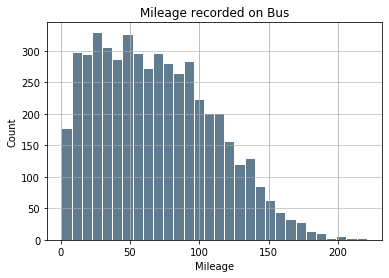

In [3]:
### Plotting Bus Distribution ###
size, scale = 1000, 10

df['milage'].plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('Mileage recorded on Bus')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

print('Mileage min is: ', df['milage'].min())
print('Mileage Max is: ', df['milage'].max())

Increment Min is:  0.0
Increment Max is:  29.0


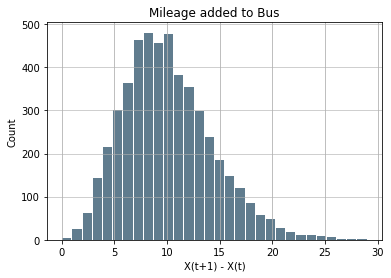

In [4]:
### Plotting Bus Distribution ###
size, scale = 1000, 10

df['t'].plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('Mileage added to Bus')
plt.xlabel('X(t+1) - X(t)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

### Max is 30 so I'll say K = 31, go from 0 to 31 ###
K = np.arange(0,30)

print('Increment Min is: ', df['t'].min())
print('Increment Max is: ', df['t'].max())

In [5]:
### Constructing g(.), p(.) and K
k = 10
maxmiles = 250
m = np.arange(0,maxmiles+1).reshape((maxmiles+1,1))

M = np.zeros((maxmiles+1,maxmiles+1))
F = np.zeros((k,k))

binlength = int(np.amax(df['milage'])/k)+1
print(binlength)

df['bin'] = (np.floor(df['milage']/binlength))+1
df['binlast'] = (np.floor(df['milage_last']/binlength))+1
df['binnext'] = (np.floor(df['milage_next']/binlength))+1

23


In [6]:


g = (df.groupby(['t'])['t'].agg('count').to_numpy())/(df['t'].count())



MYF = np.zeros((len(m),len(m)))
for i in range(0,len(m)):
    if i < len(m)-30:
        MYF[i,i:i+30] = g
    if i >= len(m)-30:
        MYF[i,i:i+(len(m)-i)] = g[0:len(m)-i]

for i in range(0,k):
    for j in range(0,k):
        mybin = i*binlength
        binmove = j*binlength
        
        F[i,j] = (MYF[mybin:(mybin+binlength),binmove:(binmove+binlength)].sum())/binlength
    if F[i,:].sum() != 1:
        difference = 1-F[i,:].sum()
        F[i,k-1] = F[i,k-1]+difference

'''### JORDANS K ###
for i in range(0,k):
    for j in range(0,k):
        F[i,j] = (df0[(df0['bin'] == i+1) & (df0['binnext']==j+1)].count()[0])/(df0[(df0['bin'] == i+1)].count()[0])

for i in range(0,k):
    Fadd[0,i] = df1[df1['binnext']==i+1].count()[0]/df1.count()[0]
    
F = np.vstack((Fadd,F))
F = np.hstack((np.zeros((k+1,1)),F))
F'''
F[0].sum()

1.0

Important Stuff

In [28]:
b = .999
x = np.arange(0,k).reshape((k,1))*binlength + (binlength)/2
theta_init = np.ones((3,1))
ev_init = (np.arange(0,k).reshape((k,1)))*(-1)

def u0(theta,x):
    return -(theta[0]*x)-theta[1]*((x/100)**2)

def u1(theta,x):
    return (-theta[2])*np.ones((len(x),1))

def gamma(theta,x,ev,f,beta = .999):
    b = beta 
    U0 = u0(theta,x)
    U1 = u1(theta,x)
    ### Numerical Correction ###
    V0 = np.add(U0, b*ev)
    V1 = np.add(U1, b*ev[0])
    V = np.maximum(V0,V1)
    U0 = U0 - V
    U1 = U1 - V
    a = np.dot(f,(V+(np.log(np.exp(V0-V) + np.exp(V1-V)))))
    return a


def pk(theta,x):
    U0 = u0(theta,x)
    U1 = u1(theta,x)
    V0 = U0 + ev
    V1 = U1 + ev[0]
    V = V0+V1
    
    ### Numerical Adjustment ###
    V1 = V1 - V.min()
    V = V - V.min()
    
    ### pk from slide 48 ###
    pk = 1 / (np.exp(V1 - V0))
    return pk

2.3.1.3

In [77]:
def jacobG(theta,x,ev,f,beta = .999):
    p = pk(theta,x)
    diagpk = np.diag(p)
    
    ### Make EV0 Matrix But That Only Has Elements in First Column ###
    EV0_pre = (np.ones((len(p),1)) - p)* beta
    EV0 = np.zeros((len(p),len(p)))
    EV0[:,0] = EV0_pre.flatten()
    
    return f*diagpk*beta + EV0

def nk(theta,x,ev,f,beta, ev_in_prime):
    G = gamma(theta,  x,  ev,  f,  beta)
    Gprime = jacobG(theta,  x,  ev_in_prime, f, beta)
    left = np.subtract(np.eye( Gprime.shape[1]  ),    Gprime)
    right = ev-G
    
    ### These deliver same thing ###
    '''step1 = (-1)*(np.linalg.solve(left, right).reshape((len(x),1)))-ev'''
    test = ev - np.dot(np.linalg.inv(left),right)
    ### step 1 returns evnext - ev ###
    return test

def kw(theta,x,ev,f,beta = .999):
    a,b = ev,ev
    evrun = np.divide( (a+b)  ,  2  )
    
    aplus = nk(theta,x,a,f,beta,evrun)
    bplus = nk(theta,x,aplus,f,beta,evrun)
    return bplus

def RustPoly(theta,x,ev_init,f,beta=.999, finaltol = 1e-14):
    
    G = gamma(theta,x,ev_init,F)
    ev = G.copy()
    tol = 500.0
    distlast = 1e-50
    
    iteration = 1
    while (finaltol < abs(tol-beta)) and (iteration < 1000):

        ### fixed point stuff ###
        G = gamma(theta,x,G,f,beta = .999)
        dist = np.max(np.abs(G-ev))

        tol = abs(dist/distlast)
        distlast = dist
        ev = G.copy()
        iteration += 1

    ### Above returns ev ###   
    tol = 100
    EV = ev
    print("POST FIXED POINT", ev, 'iterations = ', iteration)
    iteration = 1
    while (tol > finaltol) and (iteration < 500000):
        EVnew = kw(theta,x,EV,f,beta)
        tol = np.linalg.norm(EVnew - EV)
        EV = EVnew
        
        if iteration % 250 == 0:
            iteration += 0
        
        iteration += 1
    print(iteration)    
    print(tol)
    return EV

In [78]:
ev = np.arange(1,k+1).reshape((k,1))
#ev_init = np.ones((k,1))
x = np.arange(0,k).reshape((k,1))*binlength + (binlength)/2
theta = np.array([.1, .1, .1])
RustPoly(theta,x,ev_init, F)

POST FIXED POINT [[1.76214332]
 [1.59676191]
 [1.58078424]
 [1.57921984]
 [1.57906788]
 [1.57905327]
 [1.57905188]
 [1.57905175]
 [1.57905173]
 [1.57905173]] iterations =  9
6
0.0


array([[83.09158784],
       [82.92620643],
       [82.91022876],
       [82.90866436],
       [82.9085124 ],
       [82.90849779],
       [82.9084964 ],
       [82.90849627],
       [82.90849625],
       [82.90849625]])

In [79]:
def likelihood(theta,x,bindata,ddata,ev_init, F, beta=.999, epset=1e-12):
        
        U0 = u0(theta,x)
        U1 = u1(theta,x)
        ev = RustPoly(theta,x,ev_init, F)
        print("HERE", ev)
        p = pk(theta,x)
        ### MAPPING from bindata->pks ###
        probs = np.zeros((len(bindata),1))
        for i in range(0,len(bindata)):
            probs[i,:] = p[int(bindata[i])-1,:]
                
        d = ddata.copy().reshape((len(ddata),1))
        test = np.multiply(d, np.log(1-probs))
        likvector = np.add(np.multiply(d,np.log(1-probs)),   np.multiply((1-d),np.log(probs)))
        likelihood = np.sum(likvector)
        
        return likelihood
    
bd = df['bin'].to_numpy()
dd = df['d'].to_numpy()
beta = .999
theta_init = np.array((.1,.1,.1))
print(likelihood(theta_init,x,bd,dd,ev,F))

POST FIXED POINT [[1.76214332]
 [1.59676191]
 [1.58078424]
 [1.57921984]
 [1.57906788]
 [1.57905327]
 [1.57905188]
 [1.57905175]
 [1.57905173]
 [1.57905173]] iterations =  9
6
0.0
HERE [[83.09158784]
 [82.92620643]
 [82.91022876]
 [82.90866436]
 [82.9085124 ]
 [82.90849779]
 [82.9084964 ]
 [82.90849627]
 [82.90849625]
 [82.90849625]]
-73960.63466202031


In [80]:
### Likelihood Gradient ###
def du0(theta,x):
    return np.hstack((-x, -(x/100)**2, np.zeros((len(x),1))))
def du1(theta,x):
    return np.hstack((np.zeros((len(x),1)),np.zeros((len(x),1)),-1*np.ones((len(x),1))))
def dG_theta(theta,x,ev,beta,f):
    U1 = u1(theta,x)
    dU1 = du1(theta,x)
    
    U0 = u0(theta,x)
    dU0 = du0(theta,x)
    
    V0 = U0 + ev
    V1 = U1 + ev[0]
    
    top = np.add(np.multiply(np.exp(V1),dU1),np.multiply(np.exp(V0),dU0))
    bottom = np.add(np.exp(V1),np.exp(V0))
    return np.dot(f,np.divide(top,bottom))

def dEV(theta,x,ev,beta,f):
    Gprime = jacobG(theta,  x,  ev, f, beta)
    dGamma = dG_theta(theta,x,ev,beta,f)
    return (np.dot(np.linalg.inv(np.eye(len(x))-Gprime) , dGamma))

def dpk(theta,ev,x,beta,f):
    U1 = u1(theta,x)
    dU1 = du1(theta,x)
    
    U0 = u0(theta,x)
    dU0 = du0(theta,x)
    
    V0 = U0 + ev
    V1 = U1 + ev[0]
    p = pk(theta,x)
    ### MAPPING from bindata->pks ###
    dev = dEV(theta,x,ev,beta,f)
    dev0 = dev[0]*np.ones((len(dev),1))
    collect = (dU1 + beta * dev0) - (dU0 + beta * dev)
    
    return -np.multiply(np.multiply(p,(1-p)), collect)

In [81]:
dpk(theta,x,ev_init,beta,F)

array([[ 3.05472441e+01,  3.05472441e-03, -3.05472441e+01],
       [ 3.22157026e+02,  6.66927713e-02, -2.29119363e+02],
       [ 3.23004027e+03,  9.58898490e-01, -1.16867898e+03],
       [ 2.53997343e+04,  1.03551515e+01, -8.78785900e+03],
       [ 1.98836144e+05,  9.88108634e+01, -4.43861157e+04],
       [ 1.41400932e+06,  8.59210098e+02, -3.21764240e+05],
       [ 1.01603030e+07,  7.09060959e+03, -1.65768897e+06],
       [ 6.92004229e+07,  5.59468718e+04, -1.18114607e+07],
       [ 4.76035159e+08,  4.29029343e+05, -6.32448244e+07],
       [ 3.16035202e+09,  3.20740533e+06, -4.57785255e+08]])

In [82]:
def likelihoodGrad(theta):
    EVINIT = np.arange(0,k)
    ev = RustPoly(theta,x,ev_init, F)
    p = pk(theta,x)
    DPK = dpk(theta,x,ev,beta,F)
    
    LGvec = np.zeros((len(dd),3))
    ### MAPPING from bindata->pks ###
    probs = np.zeros((len(bd),1))
    for i in range(0,len(bd)):
        probs[i,:] = p[int(bd[i])-1,:]
    
    for i in range(0,len(LGvec)):
        LGvec[i,:] = (dd[i]/(1-p[int(bd[i])-1,:])) * (-DPK[int(bd[i])-1,:]) + ((1-dd[i])/(p[int(bd[i])-1,:])) * (DPK[int(bd[i])-1,:])
    return (-1)*LGvec.sum(axis=0)

def optf(theta):
    return (-1)*likelihood(theta,x,bd,dd,ev_init, F, beta=.999, epset=1e-12)

In [86]:
### Set up for optimization ###

ev_init = np.arange(1,k+1).reshape((k,1))
#ev_init = np.ones((k,1))
x = np.arange(0,k).reshape((k,1))*binlength + (binlength)/2
theta = np.array([.1, .1, .1])
beta = .999
print(optf(theta))
print(likelihoodGrad(theta))

POST FIXED POINT [[1.76214332]
 [1.59676191]
 [1.58078424]
 [1.57921984]
 [1.57906788]
 [1.57905327]
 [1.57905188]
 [1.57905175]
 [1.57905173]
 [1.57905173]] iterations =  9
6
0.0
HERE [[83.09158784]
 [82.92620643]
 [82.91022876]
 [82.90866436]
 [82.9085124 ]
 [82.90849779]
 [82.9084964 ]
 [82.90849627]
 [82.90849625]
 [82.90849625]]
73960.63466202031
POST FIXED POINT [[1.76214332]
 [1.59676191]
 [1.58078424]
 [1.57921984]
 [1.57906788]
 [1.57905327]
 [1.57905188]
 [1.57905175]
 [1.57905173]
 [1.57905173]] iterations =  9
6
0.0
[ 4.44550578e+10  3.68434850e+08 -1.94341613e+09]


In [89]:
results = minimize(optf,np.array([.5,.5,.5]))
results = minimize(optf,np.array([.01,.25,.4]), jac = likelihoodGrad) 

POST FIXED POINT [[-0.98917346]
 [-0.9921335 ]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]] iterations =  4
3
0.0
HERE [[-497.03993702]
 [-497.04289706]
 [-497.04289709]
 [-497.04289709]
 [-497.04289709]
 [-497.04289709]
 [-497.04289709]
 [-497.04289709]
 [-497.04289709]
 [-497.04289709]]
POST FIXED POINT [[-0.98917347]
 [-0.9921335 ]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]] iterations =  4
500000
1.79574954904454e-10
HERE [[-497.03993753]
 [-497.04289757]
 [-497.04289759]
 [-497.04289759]
 [-497.04289759]
 [-497.04289759]
 [-497.04289759]
 [-497.04289759]
 [-497.04289759]
 [-497.04289759]]
POST FIXED POINT [[-0.98917346]
 [-0.9921335 ]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]
 [-0.99213353]] iterations =  4
3
0.0
HERE [[-497.03993703]
 [-497.04289706]
 [-497.04289709]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


500000
0.0005393548862324412
HERE [[ 49.96945635]
 [ 44.91651666]
 [ 73.56408277]
 [105.27648708]
 [112.10416044]
 [150.4015539 ]
 [163.63836199]
 [183.96933901]
 [218.5574378 ]
 [198.60863476]]
POST FIXED POINT [[ 49.96945495]
 [ 85.82313616]
 [121.52614411]
 [157.07661114]
 [192.47453723]
 [227.71991812]
 [262.80921749]
 [296.7611295 ]
 [324.61921358]
 [336.94131416]] iterations =  3
500000
0.0005393549521620349
HERE [[ 49.96945495]
 [ 44.91650777]
 [ 73.56406008]
 [105.27646931]
 [112.10413404]
 [150.40151545]
 [163.63833713]
 [183.96928227]
 [218.5574061 ]
 [198.60857996]]
POST FIXED POINT [[ 49.96945635]
 [ 85.82313857]
 [121.52614754]
 [157.07661557]
 [192.47454267]
 [227.71992455]
 [262.80922492]
 [296.7611379 ]
 [324.61922277]
 [336.9413237 ]] iterations =  3
500000
0.0005393548860692971
HERE [[ 49.96945635]
 [ 44.91651664]
 [ 73.56408273]
 [105.27648703]
 [112.10416037]
 [150.4015538 ]
 [163.63836189]
 [183.96933885]
 [218.55743765]
 [198.60863457]]
POST FIXED POINT [[ 49.9694

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.


POST FIXED POINT [[ 32290.06257035]
 [ 55996.47519331]
 [ 79704.77542029]
 [103414.96325129]
 [127127.03868519]
 [150840.99894676]
 [174554.55235446]
 [197631.52083726]
 [216737.54136078]
 [225263.20411017]] iterations =  3
2
nan
HERE [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
POST FIXED POINT [[ 32290.06257035]
 [ 55996.47519331]
 [ 79704.77542029]
 [103414.96325129]
 [127127.03868519]
 [150840.99894676]
 [174554.55235446]
 [197631.52083726]
 [216737.54136078]
 [225263.20411017]] iterations =  3
2
nan
HERE [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
POST FIXED POINT [[ 32290.06256895]
 [ 55996.47519088]
 [ 79704.77541684]
 [103414.96324681]
 [127127.03867968]
 [150840.99894023]
 [174554.5523469 ]
 [197631.5208287 ]
 [216737.54135139]
 [225263.20410041]] iterations =  3
2
nan
HERE [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
POST FIXED POINT [[ 32290.06257035]
 [ 55996.4751933 ]
 [ 79704.77542026]
 [103414

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

# IF YOU WANTED TO USE JACOBIAN USE THIS: THERE IS HOWEVER A BUG


In [75]:
results.x

array([0.01, 0.25, 0.48])